# Spooky author classification challenge

- Predict the author based on snippets from their books.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer 

from sklearn.preprocessing import StandardScaler,LabelEncoder


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, log_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD


from keras.models import Model, Sequential
from keras.layers import Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils import np_utils

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_sub = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
print(train.shape)
print(test.shape)

(19579, 3)
(8392, 2)


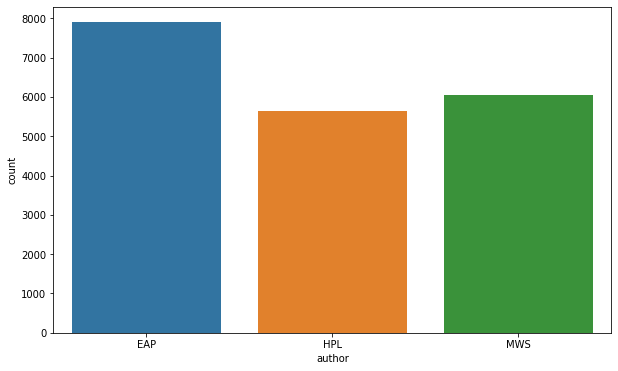

In [5]:
plt.figure(figsize = (10,6))
sns.countplot(train.author);

There's only a slight imbalance in the target class.

- **Map the author name abbreviations to integers.**

In [6]:
lbl_enc = LabelEncoder()
lbl_enc.fit(train.author)
train.loc[:, 'author'] = lbl_enc.transform(train.author)

### Text preprocessing
- Remove stopwords
- Lemmatize

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 



def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    words = [w for w in tokenizer.tokenize(text.lower()) if not w in stop_words]  # convert to lowercase and remove stopwords
##    words = [w for w in words if len(w)>2] # remove words less than 3 letters long, not used here
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w, pos= get_wordnet_pos(w)) for w in words]) ## lemmatization
    return lemmatized_text

In [8]:
# Apply the preprocessing steps to the train text adn the test text
train.loc[:, 'text'] = train.text.apply(lambda text: preprocess_text(text))
test.loc[:, 'text'] = test.text.apply(lambda text: preprocess_text(text))

In [9]:
train.text.apply(lambda snippet: len(snippet)).describe()

count    19579.000000
mean        88.644568
std         65.975348
min          0.000000
25%         46.000000
50%         76.000000
75%        116.000000
max       2854.000000
Name: text, dtype: float64

- The texts have a mean length of ~ 88 characters.
- Few texts have zero length because they consist only of stopwords. We would remove those training examples since they are redundant.

In [10]:
ind_to_drop = np.where(train.text.apply(lambda s: len(s)==0))[0]
ind_to_drop

array([ 477, 1023, 3601, 8654])

In [11]:
train = train.drop(ind_to_drop,axis=0)

max length: 2854


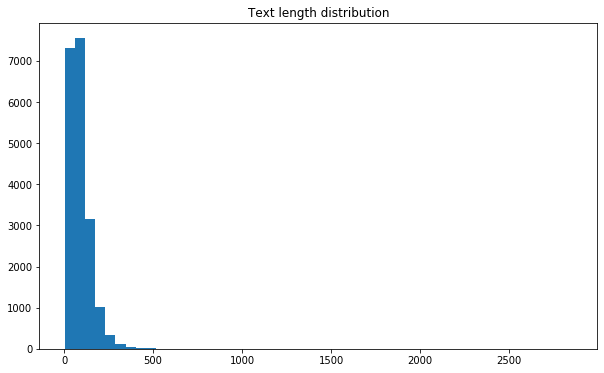

In [12]:
# Distribution of the text lengths (characters)

MAX_LENGTH = max(map(len, train.text))
print("max length:", MAX_LENGTH)
plt.figure(figsize = (10,6))
plt.title('Text length distribution')
plt.hist(list(map(len, train.text)), bins=50);

### Train-test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
                                                  shuffle=True, random_state=999, stratify = train.author)

### Vectorizer
- I've tried both TF-IDF and Count vectorizer.

In [150]:
# Consider unigrams through tri-grams for word level vectorizers, consider only top 30000 tokens.


tfidf = TfidfVectorizer(ngram_range = (1,3), strip_accents= 'unicode',
                       max_df= 0.8,  analyzer= 'word', 
                       max_features = 30000, sublinear_tf=True)


count_vec = CountVectorizer(ngram_range = (1,3), strip_accents= 'unicode',
                       max_df= 0.8, analyzer= 'word', 
                       max_features = 30000)

tfidf_char = TfidfVectorizer(ngram_range = (1,6), strip_accents= 'unicode',
                        analyzer= 'char', max_features = 50000,
                        sublinear_tf=True)

## Fit on the training set
tfidf.fit(X_train.text)
count_vec.fit(X_train.text)
tfidf_char.fit(X_train.text)

# Transform both the training set and the test set with the transformer
tfidf_train = tfidf.transform(X_train.text)
tfidf_test = tfidf.transform(X_test.text)

countvec_train = count_vec.transform(X_train.text)
countvec_test = count_vec.transform(X_test.text)

train_tfidf_char = tfidf_char.transform(X_train.text)
test_tfidf_char = tfidf_char.transform(X_test.text)

In [151]:
print(tfidf_train.shape)
print(tfidf_test.shape)
print(countvec_train.shape)
print(countvec_test.shape)
print(train_tfidf_char.shape)
print(test_tfidf_char.shape)

(15660, 30000)
(3915, 30000)
(15660, 30000)
(3915, 30000)
(15660, 50000)
(3915, 50000)


In [79]:
def get_top_n_tokens(vectorizer, vectorizer_name, df, top_n = 5):

    feature_names = vectorizer.get_feature_names()
    scores = np.sum(df.A, axis=0,keepdims=False)
    p=[]
    for tag, score in zip(feature_names, scores):
        p.append((tag, score))
    scores_df = pd.DataFrame(p,columns=['token', '%s score'%(vectorizer_name)]).sort_values(by = '%s score'%(vectorizer_name), ascending=False)
    return scores_df.head(top_n)

In [80]:
get_top_n_tokens(tfidf, 'tfidf', tfidf_train, top_n = 5)

,token,tfidf score
16059,one,153.268729
23196,say,142.468012
4185,could,137.805287
27918,upon,133.302840
29508,would,125.297556


In [81]:
get_top_n_tokens(count_vec, 'Count_vec', countvec_train, top_n = 5)

,token,Count_vec score
16059,one,1337
27918,upon,1150
4185,could,1077
23196,say,984
29508,would,962


### Predictive modelling

In [82]:
def grid_search(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None,verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=5, verbose =verbose)
    gs.fit(X, y)
    print ("Best parameter values: {}\n Best mean CV score = {:.4} and std. dev. = {:.4}".format(gs.best_params_ , 
                                                                      gs.best_score_, 
                                                                      gs.cv_results_['std_test_score'][gs.best_index_]))
    best = gs.best_estimator_
    return best

def show_metrics(y_test,y_pred, y_pred_proba):
    print(classification_report(y_test, y_pred ))
    display(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns= ['Predicted EAP', 'Predicted HPL', 'predicted MWS'], 
                         index = ['Actual EAP', 'Actual HPL', 'Actual MWS']))
    print('The multiclass logloss is {}'.format(log_loss(y_test, y_pred_proba)))
    
mlogloss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

### Naive Bayes

In [160]:
## With tfidf word-level features 

clf_mulNB = MultinomialNB()
parameters = {'alpha': np.arange(0.01, 0.1, 0.01)}
mulNB_model = grid_search(clf_mulNB, parameters, tfidf_train, y_train, n_folds=5, score_func= mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,mulNB_model.predict_proba(tfidf_train))))
print('Test logloss: {:.4}'.format(log_loss(y_test,mulNB_model.predict_proba(tfidf_test))))

Best parameter values: {'alpha': 0.04}
 Best mean CV score = -0.4299 and std. dev. = 0.004003
Train logloss: 0.1407
Test logloss: 0.4197


In [157]:
# With word count features

clf_mulNBcount = MultinomialNB()
clf_mulNBcount.fit(countvec_train, y_train)
print('Train logloss: {:.4}'.format(log_loss(y_train,clf_mulNBcount.predict_proba(countvec_train))))
print('Test logloss: {:.4}'.format(log_loss(y_test,clf_mulNBcount.predict_proba(countvec_test))))

Train logloss: 0.1975
Test logloss: 0.4559


In [163]:
## With tfidf char-level features 

clf_mulNB_char = MultinomialNB()
parameters = {'alpha': [0.5,1,2]}
mulNB_tfidf_char = grid_search(clf_mulNB_char, parameters, train_tfidf_char, y_train, n_folds = 5, score_func= mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,mulNB_tfidf_char.predict_proba(train_tfidf_char))))
print('Test logloss: {:.4}'.format(log_loss(y_test,mulNB_tfidf_char.predict_proba(test_tfidf_char))))

Best parameter values: {'alpha': 0.5}
 Best mean CV score = -0.5687 and std. dev. = 0.01026
Train logloss: 0.4265
Test logloss: 0.5535


In [98]:
test_tfidf = tfidf.transform(test.text)
pred_mulNB = mulNB_model.predict_proba(test_tfidf)
submission_df = pd.read_csv('../input/sample_submission.csv')
submission_df.iloc[:, [1,2,3]] = pred_mulNB
submission_df.to_csv('submit.csv', index=False)

#### Logistic regression

In [144]:
# with tf-idf word features

clf_logreg = LogisticRegression(solver = 'sag',random_state=23, class_weight= 'balanced')
parameters = {'C': np.arange(1,30,2)}
logreg_model_tfidf = grid_search(clf_logreg, parameters, tfidf_train, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,logreg_model_tfidf.predict_proba(tfidf_train))))
print('Test logloss: {:.4}'.format(log_loss(y_test,logreg_model_tfidf.predict_proba(tfidf_test))))

Best parameter values: {'C': 13}
 Best mean CV score = -0.4807 and std. dev. = 0.007999
Train logloss: 0.1023
Test logloss: 0.458


In [162]:
# With word count features

clf_logreg_count = LogisticRegression(solver = 'sag', random_state=23, class_weight= 'balanced', max_iter = 1000)
parameters = {'C': [0.1, 1, 10]}
logreg_model_count = grid_search(clf_logreg_count, parameters, countvec_train, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,logreg_model_count.predict_proba(countvec_train))))
print('Test logloss: {:.4}'.format(log_loss(y_test,logreg_model_count.predict_proba(countvec_test))))

Best parameter values: {'C': 1}
 Best mean CV score = -0.4943 and std. dev. = 0.01323
Train logloss: 0.1504
Test logloss: 0.4703


In [173]:
# Perform SVD with tf-idf char level features

svd = TruncatedSVD(n_components = 100)
svd.fit(train_tfidf_char)
train_svd_tfidf = svd.transform(train_tfidf_char)
test_svd_tfidf = svd.transform(test_tfidf_char)

In [174]:
logreg_tfidf_svd = LogisticRegression(random_state=23, class_weight= 'balanced')
parameters = {'C': np.arange(0.1,1,0.01)}
logreg_model_svd = grid_search(logreg_tfidf_svd, parameters, train_svd_tfidf, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,logreg_model_svd.predict_proba(train_svd_tfidf))))
print('Test logloss: {:.4}'.format(log_loss(y_test,logreg_model_svd.predict_proba(test_svd_tfidf))))

Best parameter values: {'C': 0.9899999999999995}
 Best mean CV score = -0.7979 and std. dev. = 0.008417
Train logloss: 0.7842
Test logloss: 0.7931


#### XGBoost

In [145]:
# with tf-idf word level features

xgb_model = XGBClassifier(max_depth= 2, n_estimators= 1000, n_jobs=-1,learning_rate=0.2, reg_lambda=1.5,
                          colsample_bytree = 0.4, colsample_bylevel = 0.5, random_state=22, subsample = 0.8)
xgb_model.fit(tfidf_train, y_train, eval_metric =  ['mlogloss'], eval_set = [(tfidf_train,y_train), (tfidf_test, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.09097	validation_1-mlogloss:1.09118
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.08335	validation_1-mlogloss:1.08378
[2]	validation_0-mlogloss:1.07378	validation_1-mlogloss:1.07539
[3]	validation_0-mlogloss:1.06361	validation_1-mlogloss:1.06563
[4]	validation_0-mlogloss:1.05738	validation_1-mlogloss:1.05973
[5]	validation_0-mlogloss:1.05092	validation_1-mlogloss:1.05374
[6]	validation_0-mlogloss:1.04354	validation_1-mlogloss:1.04712
[7]	validation_0-mlogloss:1.03880	validation_1-mlogloss:1.04173
[8]	validation_0-mlogloss:1.03359	validation_1-mlogloss:1.03693
[9]	validation_0-mlogloss:1.02841	validation_1-mlogloss:1.03136
[10]	validation_0-mlogloss:1.02420	validation_1-mlogloss:1.02740
[11]	validation_0-mlogloss:1.02001	validation_1-mlogloss:1.02376
[12]	validation_0-mlogloss:1.01669	validation_1-mlogloss:1.0201

[124]	validation_0-mlogloss:0.82739	validation_1-mlogloss:0.84987
[125]	validation_0-mlogloss:0.82637	validation_1-mlogloss:0.84889
[126]	validation_0-mlogloss:0.82537	validation_1-mlogloss:0.84793
[127]	validation_0-mlogloss:0.82441	validation_1-mlogloss:0.84711
[128]	validation_0-mlogloss:0.82345	validation_1-mlogloss:0.84637
[129]	validation_0-mlogloss:0.82249	validation_1-mlogloss:0.84583
[130]	validation_0-mlogloss:0.82161	validation_1-mlogloss:0.84490
[131]	validation_0-mlogloss:0.82060	validation_1-mlogloss:0.84401
[132]	validation_0-mlogloss:0.81967	validation_1-mlogloss:0.84322
[133]	validation_0-mlogloss:0.81869	validation_1-mlogloss:0.84237
[134]	validation_0-mlogloss:0.81783	validation_1-mlogloss:0.84161
[135]	validation_0-mlogloss:0.81693	validation_1-mlogloss:0.84116
[136]	validation_0-mlogloss:0.81601	validation_1-mlogloss:0.84015
[137]	validation_0-mlogloss:0.81507	validation_1-mlogloss:0.83974
[138]	validation_0-mlogloss:0.81415	validation_1-mlogloss:0.83912
[139]	vali

[249]	validation_0-mlogloss:0.73484	validation_1-mlogloss:0.77834
[250]	validation_0-mlogloss:0.73430	validation_1-mlogloss:0.77793
[251]	validation_0-mlogloss:0.73368	validation_1-mlogloss:0.77737
[252]	validation_0-mlogloss:0.73307	validation_1-mlogloss:0.77685
[253]	validation_0-mlogloss:0.73253	validation_1-mlogloss:0.77645
[254]	validation_0-mlogloss:0.73197	validation_1-mlogloss:0.77602
[255]	validation_0-mlogloss:0.73132	validation_1-mlogloss:0.77559
[256]	validation_0-mlogloss:0.73078	validation_1-mlogloss:0.77512
[257]	validation_0-mlogloss:0.73022	validation_1-mlogloss:0.77450
[258]	validation_0-mlogloss:0.72963	validation_1-mlogloss:0.77390
[259]	validation_0-mlogloss:0.72908	validation_1-mlogloss:0.77330
[260]	validation_0-mlogloss:0.72854	validation_1-mlogloss:0.77304
[261]	validation_0-mlogloss:0.72797	validation_1-mlogloss:0.77270
[262]	validation_0-mlogloss:0.72740	validation_1-mlogloss:0.77214
[263]	validation_0-mlogloss:0.72682	validation_1-mlogloss:0.77174
[264]	vali

[374]	validation_0-mlogloss:0.67269	validation_1-mlogloss:0.73194
[375]	validation_0-mlogloss:0.67226	validation_1-mlogloss:0.73158
[376]	validation_0-mlogloss:0.67183	validation_1-mlogloss:0.73128
[377]	validation_0-mlogloss:0.67138	validation_1-mlogloss:0.73104
[378]	validation_0-mlogloss:0.67097	validation_1-mlogloss:0.73088
[379]	validation_0-mlogloss:0.67057	validation_1-mlogloss:0.73061
[380]	validation_0-mlogloss:0.67014	validation_1-mlogloss:0.73020
[381]	validation_0-mlogloss:0.66973	validation_1-mlogloss:0.73003
[382]	validation_0-mlogloss:0.66929	validation_1-mlogloss:0.72979
[383]	validation_0-mlogloss:0.66887	validation_1-mlogloss:0.72948
[384]	validation_0-mlogloss:0.66842	validation_1-mlogloss:0.72897
[385]	validation_0-mlogloss:0.66800	validation_1-mlogloss:0.72874
[386]	validation_0-mlogloss:0.66760	validation_1-mlogloss:0.72840
[387]	validation_0-mlogloss:0.66717	validation_1-mlogloss:0.72794
[388]	validation_0-mlogloss:0.66674	validation_1-mlogloss:0.72747
[389]	vali

[499]	validation_0-mlogloss:0.62555	validation_1-mlogloss:0.70030
[500]	validation_0-mlogloss:0.62523	validation_1-mlogloss:0.70005
[501]	validation_0-mlogloss:0.62491	validation_1-mlogloss:0.69987
[502]	validation_0-mlogloss:0.62457	validation_1-mlogloss:0.69961
[503]	validation_0-mlogloss:0.62422	validation_1-mlogloss:0.69937
[504]	validation_0-mlogloss:0.62388	validation_1-mlogloss:0.69917
[505]	validation_0-mlogloss:0.62357	validation_1-mlogloss:0.69876
[506]	validation_0-mlogloss:0.62325	validation_1-mlogloss:0.69856
[507]	validation_0-mlogloss:0.62292	validation_1-mlogloss:0.69853
[508]	validation_0-mlogloss:0.62258	validation_1-mlogloss:0.69843
[509]	validation_0-mlogloss:0.62225	validation_1-mlogloss:0.69831
[510]	validation_0-mlogloss:0.62191	validation_1-mlogloss:0.69805
[511]	validation_0-mlogloss:0.62153	validation_1-mlogloss:0.69779
[512]	validation_0-mlogloss:0.62120	validation_1-mlogloss:0.69749
[513]	validation_0-mlogloss:0.62087	validation_1-mlogloss:0.69715
[514]	vali

[624]	validation_0-mlogloss:0.58733	validation_1-mlogloss:0.67549
[625]	validation_0-mlogloss:0.58703	validation_1-mlogloss:0.67537
[626]	validation_0-mlogloss:0.58677	validation_1-mlogloss:0.67514
[627]	validation_0-mlogloss:0.58650	validation_1-mlogloss:0.67493
[628]	validation_0-mlogloss:0.58623	validation_1-mlogloss:0.67473
[629]	validation_0-mlogloss:0.58596	validation_1-mlogloss:0.67445
[630]	validation_0-mlogloss:0.58570	validation_1-mlogloss:0.67437
[631]	validation_0-mlogloss:0.58542	validation_1-mlogloss:0.67419
[632]	validation_0-mlogloss:0.58515	validation_1-mlogloss:0.67386
[633]	validation_0-mlogloss:0.58488	validation_1-mlogloss:0.67366
[634]	validation_0-mlogloss:0.58459	validation_1-mlogloss:0.67344
[635]	validation_0-mlogloss:0.58432	validation_1-mlogloss:0.67305
[636]	validation_0-mlogloss:0.58405	validation_1-mlogloss:0.67297
[637]	validation_0-mlogloss:0.58380	validation_1-mlogloss:0.67286
[638]	validation_0-mlogloss:0.58353	validation_1-mlogloss:0.67273
[639]	vali

[749]	validation_0-mlogloss:0.55542	validation_1-mlogloss:0.65515
[750]	validation_0-mlogloss:0.55519	validation_1-mlogloss:0.65486
[751]	validation_0-mlogloss:0.55496	validation_1-mlogloss:0.65485
[752]	validation_0-mlogloss:0.55473	validation_1-mlogloss:0.65475
[753]	validation_0-mlogloss:0.55448	validation_1-mlogloss:0.65462
[754]	validation_0-mlogloss:0.55426	validation_1-mlogloss:0.65459
[755]	validation_0-mlogloss:0.55400	validation_1-mlogloss:0.65453
[756]	validation_0-mlogloss:0.55377	validation_1-mlogloss:0.65452
[757]	validation_0-mlogloss:0.55353	validation_1-mlogloss:0.65448
[758]	validation_0-mlogloss:0.55327	validation_1-mlogloss:0.65426
[759]	validation_0-mlogloss:0.55304	validation_1-mlogloss:0.65417
[760]	validation_0-mlogloss:0.55280	validation_1-mlogloss:0.65408
[761]	validation_0-mlogloss:0.55256	validation_1-mlogloss:0.65386
[762]	validation_0-mlogloss:0.55234	validation_1-mlogloss:0.65388
[763]	validation_0-mlogloss:0.55210	validation_1-mlogloss:0.65391
[764]	vali

[874]	validation_0-mlogloss:0.52762	validation_1-mlogloss:0.63901
[875]	validation_0-mlogloss:0.52742	validation_1-mlogloss:0.63910
[876]	validation_0-mlogloss:0.52721	validation_1-mlogloss:0.63903
[877]	validation_0-mlogloss:0.52700	validation_1-mlogloss:0.63887
[878]	validation_0-mlogloss:0.52680	validation_1-mlogloss:0.63864
[879]	validation_0-mlogloss:0.52658	validation_1-mlogloss:0.63840
[880]	validation_0-mlogloss:0.52637	validation_1-mlogloss:0.63833
[881]	validation_0-mlogloss:0.52617	validation_1-mlogloss:0.63812
[882]	validation_0-mlogloss:0.52597	validation_1-mlogloss:0.63807
[883]	validation_0-mlogloss:0.52577	validation_1-mlogloss:0.63792
[884]	validation_0-mlogloss:0.52557	validation_1-mlogloss:0.63785
[885]	validation_0-mlogloss:0.52536	validation_1-mlogloss:0.63791
[886]	validation_0-mlogloss:0.52518	validation_1-mlogloss:0.63797
[887]	validation_0-mlogloss:0.52496	validation_1-mlogloss:0.63773
[888]	validation_0-mlogloss:0.52474	validation_1-mlogloss:0.63755
[889]	vali

[999]	validation_0-mlogloss:0.50342	validation_1-mlogloss:0.62588


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=22, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [34]:
# With Count features

xgb_model_count = XGBClassifier(max_depth= 2, n_estimators=1500, n_jobs=-1,learning_rate=0.2, reg_lambda=1.5,
                          colsample_bytree = 0.5, colsample_bylevel = 0.5, random_state=22, subsample = 0.8)

xgb_model_count.fit(countvec_train, y_train, eval_metric =  ['mlogloss'], eval_set = [(countvec_train,y_train), (countvec_test, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.09017	validation_1-mlogloss:1.09045
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.08201	validation_1-mlogloss:1.08237
[2]	validation_0-mlogloss:1.07403	validation_1-mlogloss:1.07426
[3]	validation_0-mlogloss:1.06330	validation_1-mlogloss:1.06395
[4]	validation_0-mlogloss:1.05578	validation_1-mlogloss:1.05675
[5]	validation_0-mlogloss:1.04964	validation_1-mlogloss:1.05041
[6]	validation_0-mlogloss:1.04485	validation_1-mlogloss:1.04511
[7]	validation_0-mlogloss:1.03946	validation_1-mlogloss:1.03984
[8]	validation_0-mlogloss:1.03453	validation_1-mlogloss:1.03500
[9]	validation_0-mlogloss:1.02903	validation_1-mlogloss:1.02953
[10]	validation_0-mlogloss:1.02530	validation_1-mlogloss:1.02567
[11]	validation_0-mlogloss:1.02024	validation_1-mlogloss:1.02089
[12]	validation_0-mlogloss:1.01668	validation_1-mlogloss:1.0172

[124]	validation_0-mlogloss:0.83478	validation_1-mlogloss:0.84769
[125]	validation_0-mlogloss:0.83386	validation_1-mlogloss:0.84686
[126]	validation_0-mlogloss:0.83292	validation_1-mlogloss:0.84609
[127]	validation_0-mlogloss:0.83203	validation_1-mlogloss:0.84520
[128]	validation_0-mlogloss:0.83115	validation_1-mlogloss:0.84451
[129]	validation_0-mlogloss:0.83026	validation_1-mlogloss:0.84377
[130]	validation_0-mlogloss:0.82937	validation_1-mlogloss:0.84285
[131]	validation_0-mlogloss:0.82850	validation_1-mlogloss:0.84213
[132]	validation_0-mlogloss:0.82758	validation_1-mlogloss:0.84125
[133]	validation_0-mlogloss:0.82664	validation_1-mlogloss:0.84029
[134]	validation_0-mlogloss:0.82574	validation_1-mlogloss:0.83969
[135]	validation_0-mlogloss:0.82490	validation_1-mlogloss:0.83873
[136]	validation_0-mlogloss:0.82405	validation_1-mlogloss:0.83805
[137]	validation_0-mlogloss:0.82318	validation_1-mlogloss:0.83756
[138]	validation_0-mlogloss:0.82233	validation_1-mlogloss:0.83683
[139]	vali

[249]	validation_0-mlogloss:0.74652	validation_1-mlogloss:0.77380
[250]	validation_0-mlogloss:0.74601	validation_1-mlogloss:0.77343
[251]	validation_0-mlogloss:0.74550	validation_1-mlogloss:0.77295
[252]	validation_0-mlogloss:0.74487	validation_1-mlogloss:0.77227
[253]	validation_0-mlogloss:0.74428	validation_1-mlogloss:0.77161
[254]	validation_0-mlogloss:0.74370	validation_1-mlogloss:0.77115
[255]	validation_0-mlogloss:0.74316	validation_1-mlogloss:0.77070
[256]	validation_0-mlogloss:0.74263	validation_1-mlogloss:0.77018
[257]	validation_0-mlogloss:0.74208	validation_1-mlogloss:0.76956
[258]	validation_0-mlogloss:0.74153	validation_1-mlogloss:0.76933
[259]	validation_0-mlogloss:0.74099	validation_1-mlogloss:0.76862
[260]	validation_0-mlogloss:0.74045	validation_1-mlogloss:0.76815
[261]	validation_0-mlogloss:0.73992	validation_1-mlogloss:0.76768
[262]	validation_0-mlogloss:0.73940	validation_1-mlogloss:0.76724
[263]	validation_0-mlogloss:0.73890	validation_1-mlogloss:0.76669
[264]	vali

[374]	validation_0-mlogloss:0.68845	validation_1-mlogloss:0.72646
[375]	validation_0-mlogloss:0.68806	validation_1-mlogloss:0.72620
[376]	validation_0-mlogloss:0.68764	validation_1-mlogloss:0.72570
[377]	validation_0-mlogloss:0.68722	validation_1-mlogloss:0.72529
[378]	validation_0-mlogloss:0.68683	validation_1-mlogloss:0.72506
[379]	validation_0-mlogloss:0.68645	validation_1-mlogloss:0.72464
[380]	validation_0-mlogloss:0.68604	validation_1-mlogloss:0.72421
[381]	validation_0-mlogloss:0.68563	validation_1-mlogloss:0.72395
[382]	validation_0-mlogloss:0.68523	validation_1-mlogloss:0.72365
[383]	validation_0-mlogloss:0.68483	validation_1-mlogloss:0.72308
[384]	validation_0-mlogloss:0.68442	validation_1-mlogloss:0.72283
[385]	validation_0-mlogloss:0.68401	validation_1-mlogloss:0.72252
[386]	validation_0-mlogloss:0.68362	validation_1-mlogloss:0.72218
[387]	validation_0-mlogloss:0.68322	validation_1-mlogloss:0.72197
[388]	validation_0-mlogloss:0.68283	validation_1-mlogloss:0.72185
[389]	vali

[499]	validation_0-mlogloss:0.64405	validation_1-mlogloss:0.69270
[500]	validation_0-mlogloss:0.64374	validation_1-mlogloss:0.69246
[501]	validation_0-mlogloss:0.64343	validation_1-mlogloss:0.69207
[502]	validation_0-mlogloss:0.64312	validation_1-mlogloss:0.69193
[503]	validation_0-mlogloss:0.64278	validation_1-mlogloss:0.69167
[504]	validation_0-mlogloss:0.64249	validation_1-mlogloss:0.69139
[505]	validation_0-mlogloss:0.64220	validation_1-mlogloss:0.69109
[506]	validation_0-mlogloss:0.64189	validation_1-mlogloss:0.69086
[507]	validation_0-mlogloss:0.64158	validation_1-mlogloss:0.69068
[508]	validation_0-mlogloss:0.64128	validation_1-mlogloss:0.69047
[509]	validation_0-mlogloss:0.64097	validation_1-mlogloss:0.69040
[510]	validation_0-mlogloss:0.64068	validation_1-mlogloss:0.69026
[511]	validation_0-mlogloss:0.64037	validation_1-mlogloss:0.68990
[512]	validation_0-mlogloss:0.64000	validation_1-mlogloss:0.68981
[513]	validation_0-mlogloss:0.63969	validation_1-mlogloss:0.68952
[514]	vali

[624]	validation_0-mlogloss:0.60870	validation_1-mlogloss:0.66618
[625]	validation_0-mlogloss:0.60845	validation_1-mlogloss:0.66602
[626]	validation_0-mlogloss:0.60821	validation_1-mlogloss:0.66588
[627]	validation_0-mlogloss:0.60796	validation_1-mlogloss:0.66569
[628]	validation_0-mlogloss:0.60771	validation_1-mlogloss:0.66553
[629]	validation_0-mlogloss:0.60746	validation_1-mlogloss:0.66521
[630]	validation_0-mlogloss:0.60720	validation_1-mlogloss:0.66509
[631]	validation_0-mlogloss:0.60694	validation_1-mlogloss:0.66493
[632]	validation_0-mlogloss:0.60667	validation_1-mlogloss:0.66470
[633]	validation_0-mlogloss:0.60643	validation_1-mlogloss:0.66454
[634]	validation_0-mlogloss:0.60618	validation_1-mlogloss:0.66434
[635]	validation_0-mlogloss:0.60593	validation_1-mlogloss:0.66416
[636]	validation_0-mlogloss:0.60567	validation_1-mlogloss:0.66405
[637]	validation_0-mlogloss:0.60542	validation_1-mlogloss:0.66382
[638]	validation_0-mlogloss:0.60516	validation_1-mlogloss:0.66353
[639]	vali

[749]	validation_0-mlogloss:0.57911	validation_1-mlogloss:0.64478
[750]	validation_0-mlogloss:0.57888	validation_1-mlogloss:0.64440
[751]	validation_0-mlogloss:0.57867	validation_1-mlogloss:0.64411
[752]	validation_0-mlogloss:0.57847	validation_1-mlogloss:0.64403
[753]	validation_0-mlogloss:0.57825	validation_1-mlogloss:0.64401
[754]	validation_0-mlogloss:0.57802	validation_1-mlogloss:0.64380
[755]	validation_0-mlogloss:0.57781	validation_1-mlogloss:0.64362
[756]	validation_0-mlogloss:0.57759	validation_1-mlogloss:0.64339
[757]	validation_0-mlogloss:0.57737	validation_1-mlogloss:0.64319
[758]	validation_0-mlogloss:0.57716	validation_1-mlogloss:0.64299
[759]	validation_0-mlogloss:0.57694	validation_1-mlogloss:0.64285
[760]	validation_0-mlogloss:0.57673	validation_1-mlogloss:0.64284
[761]	validation_0-mlogloss:0.57652	validation_1-mlogloss:0.64265
[762]	validation_0-mlogloss:0.57630	validation_1-mlogloss:0.64246
[763]	validation_0-mlogloss:0.57607	validation_1-mlogloss:0.64234
[764]	vali

[874]	validation_0-mlogloss:0.55396	validation_1-mlogloss:0.62707
[875]	validation_0-mlogloss:0.55378	validation_1-mlogloss:0.62703
[876]	validation_0-mlogloss:0.55359	validation_1-mlogloss:0.62702
[877]	validation_0-mlogloss:0.55342	validation_1-mlogloss:0.62688
[878]	validation_0-mlogloss:0.55324	validation_1-mlogloss:0.62686
[879]	validation_0-mlogloss:0.55305	validation_1-mlogloss:0.62671
[880]	validation_0-mlogloss:0.55287	validation_1-mlogloss:0.62668
[881]	validation_0-mlogloss:0.55265	validation_1-mlogloss:0.62659
[882]	validation_0-mlogloss:0.55247	validation_1-mlogloss:0.62651
[883]	validation_0-mlogloss:0.55228	validation_1-mlogloss:0.62631
[884]	validation_0-mlogloss:0.55209	validation_1-mlogloss:0.62623
[885]	validation_0-mlogloss:0.55192	validation_1-mlogloss:0.62608
[886]	validation_0-mlogloss:0.55174	validation_1-mlogloss:0.62594
[887]	validation_0-mlogloss:0.55152	validation_1-mlogloss:0.62582
[888]	validation_0-mlogloss:0.55134	validation_1-mlogloss:0.62574
[889]	vali

[999]	validation_0-mlogloss:0.53180	validation_1-mlogloss:0.61272
[1000]	validation_0-mlogloss:0.53159	validation_1-mlogloss:0.61247
[1001]	validation_0-mlogloss:0.53142	validation_1-mlogloss:0.61240
[1002]	validation_0-mlogloss:0.53125	validation_1-mlogloss:0.61231
[1003]	validation_0-mlogloss:0.53106	validation_1-mlogloss:0.61213
[1004]	validation_0-mlogloss:0.53089	validation_1-mlogloss:0.61200
[1005]	validation_0-mlogloss:0.53074	validation_1-mlogloss:0.61199
[1006]	validation_0-mlogloss:0.53056	validation_1-mlogloss:0.61181
[1007]	validation_0-mlogloss:0.53039	validation_1-mlogloss:0.61171
[1008]	validation_0-mlogloss:0.53024	validation_1-mlogloss:0.61163
[1009]	validation_0-mlogloss:0.53009	validation_1-mlogloss:0.61145
[1010]	validation_0-mlogloss:0.52990	validation_1-mlogloss:0.61118
[1011]	validation_0-mlogloss:0.52972	validation_1-mlogloss:0.61113
[1012]	validation_0-mlogloss:0.52957	validation_1-mlogloss:0.61105
[1013]	validation_0-mlogloss:0.52941	validation_1-mlogloss:0.61

[1122]	validation_0-mlogloss:0.51253	validation_1-mlogloss:0.60001
[1123]	validation_0-mlogloss:0.51239	validation_1-mlogloss:0.59993
[1124]	validation_0-mlogloss:0.51226	validation_1-mlogloss:0.59984
[1125]	validation_0-mlogloss:0.51209	validation_1-mlogloss:0.59972
[1126]	validation_0-mlogloss:0.51194	validation_1-mlogloss:0.59962
[1127]	validation_0-mlogloss:0.51180	validation_1-mlogloss:0.59958
[1128]	validation_0-mlogloss:0.51167	validation_1-mlogloss:0.59955
[1129]	validation_0-mlogloss:0.51151	validation_1-mlogloss:0.59944
[1130]	validation_0-mlogloss:0.51136	validation_1-mlogloss:0.59932
[1131]	validation_0-mlogloss:0.51121	validation_1-mlogloss:0.59925
[1132]	validation_0-mlogloss:0.51107	validation_1-mlogloss:0.59918
[1133]	validation_0-mlogloss:0.51091	validation_1-mlogloss:0.59898
[1134]	validation_0-mlogloss:0.51078	validation_1-mlogloss:0.59888
[1135]	validation_0-mlogloss:0.51062	validation_1-mlogloss:0.59872
[1136]	validation_0-mlogloss:0.51046	validation_1-mlogloss:0.5

[1245]	validation_0-mlogloss:0.49519	validation_1-mlogloss:0.58788
[1246]	validation_0-mlogloss:0.49506	validation_1-mlogloss:0.58776
[1247]	validation_0-mlogloss:0.49493	validation_1-mlogloss:0.58763
[1248]	validation_0-mlogloss:0.49479	validation_1-mlogloss:0.58756
[1249]	validation_0-mlogloss:0.49465	validation_1-mlogloss:0.58747
[1250]	validation_0-mlogloss:0.49453	validation_1-mlogloss:0.58746
[1251]	validation_0-mlogloss:0.49441	validation_1-mlogloss:0.58730
[1252]	validation_0-mlogloss:0.49427	validation_1-mlogloss:0.58718
[1253]	validation_0-mlogloss:0.49413	validation_1-mlogloss:0.58708
[1254]	validation_0-mlogloss:0.49401	validation_1-mlogloss:0.58709
[1255]	validation_0-mlogloss:0.49387	validation_1-mlogloss:0.58702
[1256]	validation_0-mlogloss:0.49373	validation_1-mlogloss:0.58698
[1257]	validation_0-mlogloss:0.49360	validation_1-mlogloss:0.58687
[1258]	validation_0-mlogloss:0.49347	validation_1-mlogloss:0.58680
[1259]	validation_0-mlogloss:0.49334	validation_1-mlogloss:0.5

[1368]	validation_0-mlogloss:0.47968	validation_1-mlogloss:0.57874
[1369]	validation_0-mlogloss:0.47957	validation_1-mlogloss:0.57860
[1370]	validation_0-mlogloss:0.47945	validation_1-mlogloss:0.57863
[1371]	validation_0-mlogloss:0.47933	validation_1-mlogloss:0.57858
[1372]	validation_0-mlogloss:0.47921	validation_1-mlogloss:0.57847
[1373]	validation_0-mlogloss:0.47910	validation_1-mlogloss:0.57835
[1374]	validation_0-mlogloss:0.47898	validation_1-mlogloss:0.57825
[1375]	validation_0-mlogloss:0.47886	validation_1-mlogloss:0.57816
[1376]	validation_0-mlogloss:0.47874	validation_1-mlogloss:0.57801
[1377]	validation_0-mlogloss:0.47863	validation_1-mlogloss:0.57791
[1378]	validation_0-mlogloss:0.47850	validation_1-mlogloss:0.57788
[1379]	validation_0-mlogloss:0.47838	validation_1-mlogloss:0.57775
[1380]	validation_0-mlogloss:0.47827	validation_1-mlogloss:0.57771
[1381]	validation_0-mlogloss:0.47814	validation_1-mlogloss:0.57763
[1382]	validation_0-mlogloss:0.47801	validation_1-mlogloss:0.5

[1491]	validation_0-mlogloss:0.46555	validation_1-mlogloss:0.56989
[1492]	validation_0-mlogloss:0.46543	validation_1-mlogloss:0.56983
[1493]	validation_0-mlogloss:0.46532	validation_1-mlogloss:0.56972
[1494]	validation_0-mlogloss:0.46521	validation_1-mlogloss:0.56963
[1495]	validation_0-mlogloss:0.46509	validation_1-mlogloss:0.56952
[1496]	validation_0-mlogloss:0.46497	validation_1-mlogloss:0.56943
[1497]	validation_0-mlogloss:0.46486	validation_1-mlogloss:0.56937
[1498]	validation_0-mlogloss:0.46475	validation_1-mlogloss:0.56935
[1499]	validation_0-mlogloss:0.46462	validation_1-mlogloss:0.56924


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=22, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [58]:
# with tf-idf char level features

xgb_model = XGBClassifier(max_depth= 3, n_estimators= 1500, n_jobs=-1,learning_rate=0.1, reg_lambda=1.5,
                          colsample_bytree = 0.4, colsample_bylevel = 0.5, random_state=22, subsample = 0.8)
xgb_model.fit(train_svd_tfidf, y_train, eval_metric =  ['mlogloss'], eval_set = [(train_svd_tfidf,y_train), (test_svd_tfidf, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.08720	validation_1-mlogloss:1.08788
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.07656	validation_1-mlogloss:1.07749
[2]	validation_0-mlogloss:1.06788	validation_1-mlogloss:1.06991
[3]	validation_0-mlogloss:1.05836	validation_1-mlogloss:1.06083
[4]	validation_0-mlogloss:1.05241	validation_1-mlogloss:1.05558
[5]	validation_0-mlogloss:1.03996	validation_1-mlogloss:1.04330
[6]	validation_0-mlogloss:1.03123	validation_1-mlogloss:1.03547
[7]	validation_0-mlogloss:1.01803	validation_1-mlogloss:1.02142
[8]	validation_0-mlogloss:1.01372	validation_1-mlogloss:1.01818
[9]	validation_0-mlogloss:1.00749	validation_1-mlogloss:1.01287
[10]	validation_0-mlogloss:1.00129	validation_1-mlogloss:1.00766
[11]	validation_0-mlogloss:0.99309	validation_1-mlogloss:0.99907
[12]	validation_0-mlogloss:0.98581	validation_1-mlogloss:0.9922

[124]	validation_0-mlogloss:0.74311	validation_1-mlogloss:0.80639
[125]	validation_0-mlogloss:0.74214	validation_1-mlogloss:0.80607
[126]	validation_0-mlogloss:0.74110	validation_1-mlogloss:0.80553
[127]	validation_0-mlogloss:0.74017	validation_1-mlogloss:0.80522
[128]	validation_0-mlogloss:0.73927	validation_1-mlogloss:0.80486
[129]	validation_0-mlogloss:0.73820	validation_1-mlogloss:0.80419
[130]	validation_0-mlogloss:0.73727	validation_1-mlogloss:0.80379
[131]	validation_0-mlogloss:0.73632	validation_1-mlogloss:0.80349
[132]	validation_0-mlogloss:0.73528	validation_1-mlogloss:0.80294
[133]	validation_0-mlogloss:0.73436	validation_1-mlogloss:0.80290
[134]	validation_0-mlogloss:0.73350	validation_1-mlogloss:0.80238
[135]	validation_0-mlogloss:0.73270	validation_1-mlogloss:0.80232
[136]	validation_0-mlogloss:0.73188	validation_1-mlogloss:0.80197
[137]	validation_0-mlogloss:0.73097	validation_1-mlogloss:0.80129
[138]	validation_0-mlogloss:0.72998	validation_1-mlogloss:0.80086
[139]	vali

[249]	validation_0-mlogloss:0.65235	validation_1-mlogloss:0.77376
[250]	validation_0-mlogloss:0.65179	validation_1-mlogloss:0.77363
[251]	validation_0-mlogloss:0.65115	validation_1-mlogloss:0.77338
[252]	validation_0-mlogloss:0.65065	validation_1-mlogloss:0.77395
[253]	validation_0-mlogloss:0.65013	validation_1-mlogloss:0.77390
[254]	validation_0-mlogloss:0.64948	validation_1-mlogloss:0.77354
[255]	validation_0-mlogloss:0.64891	validation_1-mlogloss:0.77402
[256]	validation_0-mlogloss:0.64834	validation_1-mlogloss:0.77401
[257]	validation_0-mlogloss:0.64780	validation_1-mlogloss:0.77382
[258]	validation_0-mlogloss:0.64721	validation_1-mlogloss:0.77356
[259]	validation_0-mlogloss:0.64656	validation_1-mlogloss:0.77350
[260]	validation_0-mlogloss:0.64604	validation_1-mlogloss:0.77330
[261]	validation_0-mlogloss:0.64557	validation_1-mlogloss:0.77326
[262]	validation_0-mlogloss:0.64500	validation_1-mlogloss:0.77300
[263]	validation_0-mlogloss:0.64446	validation_1-mlogloss:0.77294
[264]	vali

[374]	validation_0-mlogloss:0.59271	validation_1-mlogloss:0.76407
[375]	validation_0-mlogloss:0.59223	validation_1-mlogloss:0.76407
[376]	validation_0-mlogloss:0.59183	validation_1-mlogloss:0.76409
[377]	validation_0-mlogloss:0.59137	validation_1-mlogloss:0.76399
[378]	validation_0-mlogloss:0.59098	validation_1-mlogloss:0.76388
[379]	validation_0-mlogloss:0.59063	validation_1-mlogloss:0.76376
[380]	validation_0-mlogloss:0.59023	validation_1-mlogloss:0.76359
[381]	validation_0-mlogloss:0.58984	validation_1-mlogloss:0.76352
[382]	validation_0-mlogloss:0.58941	validation_1-mlogloss:0.76345
[383]	validation_0-mlogloss:0.58901	validation_1-mlogloss:0.76343
[384]	validation_0-mlogloss:0.58854	validation_1-mlogloss:0.76314
[385]	validation_0-mlogloss:0.58815	validation_1-mlogloss:0.76301
[386]	validation_0-mlogloss:0.58771	validation_1-mlogloss:0.76285
[387]	validation_0-mlogloss:0.58722	validation_1-mlogloss:0.76252
[388]	validation_0-mlogloss:0.58682	validation_1-mlogloss:0.76240
[389]	vali

[499]	validation_0-mlogloss:0.54702	validation_1-mlogloss:0.75794
[500]	validation_0-mlogloss:0.54671	validation_1-mlogloss:0.75784
[501]	validation_0-mlogloss:0.54641	validation_1-mlogloss:0.75778
[502]	validation_0-mlogloss:0.54612	validation_1-mlogloss:0.75781
[503]	validation_0-mlogloss:0.54580	validation_1-mlogloss:0.75779
[504]	validation_0-mlogloss:0.54544	validation_1-mlogloss:0.75763
[505]	validation_0-mlogloss:0.54506	validation_1-mlogloss:0.75749
[506]	validation_0-mlogloss:0.54473	validation_1-mlogloss:0.75732
[507]	validation_0-mlogloss:0.54453	validation_1-mlogloss:0.75725
[508]	validation_0-mlogloss:0.54418	validation_1-mlogloss:0.75731
[509]	validation_0-mlogloss:0.54380	validation_1-mlogloss:0.75729
[510]	validation_0-mlogloss:0.54351	validation_1-mlogloss:0.75716
[511]	validation_0-mlogloss:0.54313	validation_1-mlogloss:0.75717
[512]	validation_0-mlogloss:0.54276	validation_1-mlogloss:0.75700
[513]	validation_0-mlogloss:0.54246	validation_1-mlogloss:0.75690
[514]	vali

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=22, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

- The model can probably be tuned futher but overall XGBoost is not a good performer on this task.

In [351]:
cv_scores_xgb = cross_val_score(xgb_model_count,countvec_train,y_train, cv = 5, scoring = mlogloss)

In [352]:
print("Mean CV score: {} and std. dev.: {}".format(np.mean(cv_scores_xgb), np.std(cv_scores_xgb)))

Mean CV score: -0.5941931347820912 and std. dev.: 0.009451509259126079


#### Summary
- Naive Bayes performed the best on this problem, based on TF-IDF and count features. It even outperforms XgBoost.
- Next I'll use Word embeddings with different classifiers.

## Word vectors (GloVe)

In [466]:
def read_glove_vecs(glove_file):
    '''
    Reads the glove embeddings from the file specified by the path.
    Returns the vocabulary, word to index mapping and the word to vector map.
    '''
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
#        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
#            index_to_words[i] = w
            i = i + 1
    return words, words_to_index, word_to_vec_map


emb_dim = 100 # Get the 100-dim Glove vectors
words, words_to_index, word_to_vec_map = read_glove_vecs('../input/glove_6B/glove.6B.{}d.txt'.format(emb_dim))

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (glove_vec_size,)
    """
    
    words = word_tokenize(sentence.lower())
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # Initialize the average word vector
    avg = np.zeros(shape = (emb_dim,))    
    # Average the word vectors.
    total = np.zeros(shape = (emb_dim,))
    for w in words:
        if w not in word_to_vec_map.keys():
            continue
        total += word_to_vec_map[w]
    if len(words) >0:
        avg = total/len(words)
#    tot_norm = total/np.sqrt(np.sum((total)**2))
    return avg

In [317]:
X_train_glove = [sentence_to_avg(x, word_to_vec_map) for x in X_train.text]
X_test_glove =  [sentence_to_avg(x, word_to_vec_map) for x in X_test.text]

X_train_glove = np.stack(X_train_glove,axis=0)
X_test_glove = np.stack(X_test_glove,axis=0)

In [318]:
# Logistic Regression with the GloVe vectors

clf_logreg_glove = LogisticRegression(random_state=23, class_weight= 'balanced', max_iter = 500)
parameters = {'C': np.arange(0.01,0.2,0.01)}
logreg_glove_model = grid_search(clf_logreg_glove, parameters, X_train_glove, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: ',log_loss(y_train,logreg_glove_model.predict_proba(X_train_glove)))
print('Test logloss: ',log_loss(y_test,logreg_glove_model.predict_proba(X_test_glove)))

Best parameter values: {'C': 0.16}
 Best mean CV score = -0.8774 and std. dev. = 0.01372
Train logloss:  0.8633228872093427
Test logloss:  0.866933263395075


- Logistic regression performs poorly with GloVe vectors compared to tf-idf vectors.

In [353]:
# XgBoost with GloVe vectors

xgb_model = XGBClassifier(max_depth= 3, n_estimators= 1000, n_jobs=-1,learning_rate= 0.1, reg_lambda=1.5,
                          colsample_bytree = 0.5, colsample_bylevel = 0.5, random_state=22, subsample = 0.8)
xgb_model.fit(X_train_glove, y_train, eval_metric =  ['mlogloss'], eval_set = [(X_train_glove,y_train), (X_test_glove, y_test)],
             early_stopping_rounds = 20)


[0]	validation_0-mlogloss:1.08616	validation_1-mlogloss:1.08702
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:1.07555	validation_1-mlogloss:1.07764
[2]	validation_0-mlogloss:1.06608	validation_1-mlogloss:1.06907
[3]	validation_0-mlogloss:1.05749	validation_1-mlogloss:1.06091
[4]	validation_0-mlogloss:1.0492	validation_1-mlogloss:1.05367
[5]	validation_0-mlogloss:1.04113	validation_1-mlogloss:1.04648
[6]	validation_0-mlogloss:1.03296	validation_1-mlogloss:1.03866
[7]	validation_0-mlogloss:1.02594	validation_1-mlogloss:1.03226
[8]	validation_0-mlogloss:1.01905	validation_1-mlogloss:1.02625
[9]	validation_0-mlogloss:1.01205	validation_1-mlogloss:1.02007
[10]	validation_0-mlogloss:1.00556	validation_1-mlogloss:1.01437
[11]	validation_0-mlogloss:1.00002	validation_1-mlogloss:1.00941
[12]	validation_0-mlogloss:0.99361	validation_1-mlogloss:1.00343

[121]	validation_0-mlogloss:0.784275	validation_1-mlogloss:0.849595
[122]	validation_0-mlogloss:0.78344	validation_1-mlogloss:0.849109
[123]	validation_0-mlogloss:0.782651	validation_1-mlogloss:0.848767
[124]	validation_0-mlogloss:0.781869	validation_1-mlogloss:0.848244
[125]	validation_0-mlogloss:0.780977	validation_1-mlogloss:0.847909
[126]	validation_0-mlogloss:0.780087	validation_1-mlogloss:0.847645
[127]	validation_0-mlogloss:0.779196	validation_1-mlogloss:0.847419
[128]	validation_0-mlogloss:0.778388	validation_1-mlogloss:0.847106
[129]	validation_0-mlogloss:0.777593	validation_1-mlogloss:0.846549
[130]	validation_0-mlogloss:0.776819	validation_1-mlogloss:0.846217
[131]	validation_0-mlogloss:0.775942	validation_1-mlogloss:0.845735
[132]	validation_0-mlogloss:0.775076	validation_1-mlogloss:0.845291
[133]	validation_0-mlogloss:0.774325	validation_1-mlogloss:0.844953
[134]	validation_0-mlogloss:0.773671	validation_1-mlogloss:0.844798
[135]	validation_0-mlogloss:0.772793	validation_1

[242]	validation_0-mlogloss:0.705115	validation_1-mlogloss:0.819498
[243]	validation_0-mlogloss:0.704514	validation_1-mlogloss:0.819339
[244]	validation_0-mlogloss:0.704023	validation_1-mlogloss:0.819215
[245]	validation_0-mlogloss:0.703418	validation_1-mlogloss:0.819248
[246]	validation_0-mlogloss:0.702957	validation_1-mlogloss:0.819284
[247]	validation_0-mlogloss:0.702505	validation_1-mlogloss:0.81927
[248]	validation_0-mlogloss:0.701945	validation_1-mlogloss:0.81902
[249]	validation_0-mlogloss:0.701354	validation_1-mlogloss:0.818907
[250]	validation_0-mlogloss:0.700882	validation_1-mlogloss:0.818825
[251]	validation_0-mlogloss:0.700382	validation_1-mlogloss:0.818729
[252]	validation_0-mlogloss:0.699856	validation_1-mlogloss:0.818778
[253]	validation_0-mlogloss:0.699349	validation_1-mlogloss:0.818535
[254]	validation_0-mlogloss:0.698849	validation_1-mlogloss:0.818547
[255]	validation_0-mlogloss:0.698363	validation_1-mlogloss:0.818569
[256]	validation_0-mlogloss:0.697846	validation_1-

[363]	validation_0-mlogloss:0.649951	validation_1-mlogloss:0.806864
[364]	validation_0-mlogloss:0.64952	validation_1-mlogloss:0.806784
[365]	validation_0-mlogloss:0.649186	validation_1-mlogloss:0.806644
[366]	validation_0-mlogloss:0.648816	validation_1-mlogloss:0.80645
[367]	validation_0-mlogloss:0.648397	validation_1-mlogloss:0.806328
[368]	validation_0-mlogloss:0.647964	validation_1-mlogloss:0.806135
[369]	validation_0-mlogloss:0.647519	validation_1-mlogloss:0.806159
[370]	validation_0-mlogloss:0.647098	validation_1-mlogloss:0.806055
[371]	validation_0-mlogloss:0.646619	validation_1-mlogloss:0.805819
[372]	validation_0-mlogloss:0.646203	validation_1-mlogloss:0.805709
[373]	validation_0-mlogloss:0.645831	validation_1-mlogloss:0.805563
[374]	validation_0-mlogloss:0.645453	validation_1-mlogloss:0.805523
[375]	validation_0-mlogloss:0.645033	validation_1-mlogloss:0.8055
[376]	validation_0-mlogloss:0.64461	validation_1-mlogloss:0.805313
[377]	validation_0-mlogloss:0.644268	validation_1-mlo

[484]	validation_0-mlogloss:0.603966	validation_1-mlogloss:0.800246
[485]	validation_0-mlogloss:0.603635	validation_1-mlogloss:0.800213
[486]	validation_0-mlogloss:0.603267	validation_1-mlogloss:0.800121
[487]	validation_0-mlogloss:0.602948	validation_1-mlogloss:0.799988
[488]	validation_0-mlogloss:0.602591	validation_1-mlogloss:0.799952
[489]	validation_0-mlogloss:0.602219	validation_1-mlogloss:0.800042
[490]	validation_0-mlogloss:0.601853	validation_1-mlogloss:0.799986
[491]	validation_0-mlogloss:0.601432	validation_1-mlogloss:0.79991
[492]	validation_0-mlogloss:0.601099	validation_1-mlogloss:0.799901
[493]	validation_0-mlogloss:0.600734	validation_1-mlogloss:0.79989
[494]	validation_0-mlogloss:0.600349	validation_1-mlogloss:0.799957
[495]	validation_0-mlogloss:0.600001	validation_1-mlogloss:0.799946
[496]	validation_0-mlogloss:0.59962	validation_1-mlogloss:0.79976
[497]	validation_0-mlogloss:0.599244	validation_1-mlogloss:0.799805
[498]	validation_0-mlogloss:0.598842	validation_1-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=22,
              reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [354]:
show_metrics(y_test, xgb_model.predict(X_test_glove), xgb_model.predict_proba(X_test_glove))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67      1579
           1       0.63      0.60      0.61      1127
           2       0.66      0.60      0.63      1209

    accuracy                           0.64      3915
   macro avg       0.64      0.64      0.64      3915
weighted avg       0.64      0.64      0.64      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1110,236,233
Actual HPL,299,677,151
Actual MWS,309,169,731


The multiclass logloss is 0.7987514578058155


### LSTM sequence model

In [467]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def tokenize(text_corpus):
    '''
    Tokenize the corpus and return the tokenizer object
    '''
    tokenizer = Tokenizer(lower=True)
    tokenizer.fit_on_texts(text_corpus)
    return tokenizer

def text_to_seq(tokenizer, text_corpus, max_len):
    '''
    Return the word indices array to be used as input for Keras Embedding layer
    Arguments:
    max_len -- Maximum sequence length to be used for padding
    '''
    tensor = tokenizer.texts_to_sequences(text_corpus)
    tensor_pad = pad_sequences(tensor,maxlen=max_len, padding='pre')
    return tensor_pad

def create_embedding_matrix(word_to_vec_map, word_index, emb_dim):
    vocab_len = len(word_index) + 1
    embedding_matrix = np.zeros(shape = (vocab_len, emb_dim))
    for word, idx in word_index.items():
        emb_vector = word_to_vec_map.get(word)
        if emb_vector is not None:
            embedding_matrix[idx,:] = emb_vector
    return embedding_matrix

def create_model(word_to_vec_map, word_index, emb_dim, max_len):
    '''
    Returns a Keras model one LSTM layer followed by two dense layers.
    
    Arguments:
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary
    emb_dim -- dimenesion of the word embedding

    Returns:
    model -- a model instance in Keras
    '''
    vocab_len = len(word_index) + 1
    embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
    embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)                             
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, recurrent_dropout=0.4, return_sequences=False))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate = 0.5))   
    model.add(Dense(units = 3, activation = 'softmax'))
    return model

In [468]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
                                                  shuffle=True, random_state=999, stratify = train.author)

lbl_enc = LabelEncoder()
lbl_enc.fit(y_train)
y_train = lbl_enc.transform(y_train)
y_test = lbl_enc.transform(y_test)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [383]:
emb_dim = 100
max_len = 150

tokenizer = tokenize(train.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_emb = text_to_seq(tokenizer, text_corpus = X_train.text, max_len = max_len)
X_test_emb = text_to_seq(tokenizer, text_corpus =  X_test.text, max_len = max_len)

print('{} training examples exceeded max_len'.format(np.sum(X_train_emb[:, max_len-1]!=0)))
print('{} test examples exceeded max_len\n'.format(np.sum(X_test_emb[:, max_len-1]!=0)))

Y_train_oh = np_utils.to_categorical(y_train, dtype = 'int32')
Y_test_oh = np_utils.to_categorical(y_test, dtype = 'int32')


K.clear_session()
model = create_model(word_to_vec_map, word_index, emb_dim, max_len)
model.summary()

Found 25943 unique tokens.
15663 training examples exceeded max_len
3916 test examples exceeded max_len

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          2594400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2

In [384]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_emb, Y_train_oh, batch_size=256, epochs=50, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/50
15663/15663 [==============================] - 159s 10ms/step - loss: 1.0145 - val_loss: 0.8545
Epoch 2/50
15663/15663 [==============================] - 148s 9ms/step - loss: 0.8819 - val_loss: 0.7925
Epoch 3/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.8413 - val_loss: 0.7706
Epoch 4/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.7986 - val_loss: 0.7513
Epoch 5/50
15663/15663 [==============================] - 146s 9ms/step - loss: 0.7810 - val_loss: 0.7251
Epoch 6/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.7585 - val_loss: 0.7046
Epoch 7/50
15663/15663 [==============================] - 143s 9ms/step - loss: 0.7422 - val_loss: 0.7130
Epoch 8/50
15663/15663 [==============================] - 136s 9ms/step - loss: 0.7343 - val_loss: 0.6938
Epoch 9/50
15663/15663 [==============================] - 136s 9ms/step - loss: 0.7058 - val_loss: 0.6

In [385]:
loss = model.evaluate(X_test_emb, Y_test_oh)
print("Logloss on test set: ", loss)

3916/3916 [==============================] - 22s 6ms/step
Logloss on test set:  0.5577361761488637


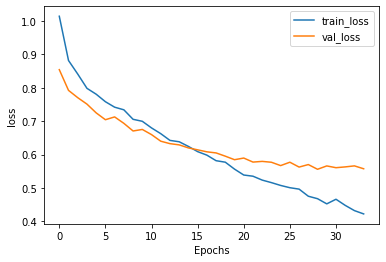

In [391]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()
    
plot_graphs(history, 'loss')
    
#plot_graphs(history, 'accuracy')

In [389]:
# Predict on unlabelled data set

test_emb = text_to_seq(tokenizer, text_corpus =  test.text, max_len = max_len)
pred_test = model.predict(test_emb)
submission_df = pd.read_csv('../input/sample_submission.csv')

submission_df.iloc[:, [1,2,3]] = pred_test

submission_df.to_csv('submit.csv', index=False)

In [394]:
## One bidirectional LSTM layer followed by two dense layers, with the final dense layer being the one with softmax activation

vocab_len = len(word_index) + 1
embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)                             
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Bidirectional(LSTM(64, recurrent_dropout=0.5, return_sequences=False)))
model2.add(Dropout(rate = 0.6))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dropout(rate = 0.6))   
model2.add(Dense(units = 3, activation = 'softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history2 = model2.fit(X_train_emb, Y_train_oh, batch_size=128, epochs=50, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/50
15663/15663 [==============================] - 159s 10ms/step - loss: 1.0470 - val_loss: 0.9197
Epoch 2/50
15663/15663 [==============================] - 193s 12ms/step - loss: 0.9362 - val_loss: 0.8276
Epoch 3/50
15663/15663 [==============================] - 175s 11ms/step - loss: 0.8726 - val_loss: 0.7880
Epoch 4/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.8328 - val_loss: 0.7581
Epoch 5/50
15663/15663 [==============================] - 173s 11ms/step - loss: 0.8110 - val_loss: 0.7322
Epoch 6/50
15663/15663 [==============================] - 180s 11ms/step - loss: 0.7888 - val_loss: 0.7248
Epoch 7/50
15663/15663 [==============================] - 189s 12ms/step - loss: 0.7671 - val_loss: 0.7002
Epoch 8/50
15663/15663 [==============================] - 181s 12ms/step - loss: 0.7440 - val_loss: 0.6934
Epoch 9/50
15663/15663 [==============================] - 164s 10ms/step - loss: 0.7307 - val_lo

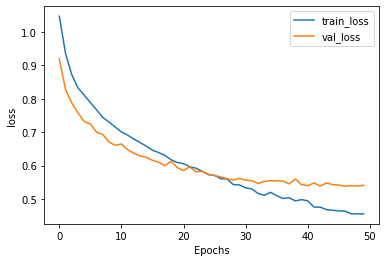

In [395]:
plot_graphs(history2, 'loss')

In [477]:
## Two LSTM layers followed by two dense layers, with the final dense layer being the one with softmax activation

vocab_len = len(word_index) + 1
embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)         
K.clear_session()
model3 = Sequential()
model3.add(embedding_layer)
model3.add(LSTM(64, recurrent_dropout=0.4, return_sequences=True))
model3.add(Dropout(rate = 0.4))
model3.add(LSTM(128, dropout = 0.6, recurrent_dropout=0.5, return_sequences=False))
model3.add(Dense(256, activation = 'relu'))
model3.add(Dropout(rate = 0.6))   
model3.add(Dense(units = 3, activation = 'softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history3 = model3.fit(X_train_emb, Y_train_oh, batch_size=128, epochs=50, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/50
15663/15663 [==============================] - 291s 19ms/step - loss: 1.0284 - val_loss: 0.8706
Epoch 2/50
15663/15663 [==============================] - 267s 17ms/step - loss: 0.9030 - val_loss: 0.8126
Epoch 3/50
15663/15663 [==============================] - 266s 17ms/step - loss: 0.8538 - val_loss: 0.7671
Epoch 4/50
15663/15663 [==============================] - 267s 17ms/step - loss: 0.8251 - val_loss: 0.7506
Epoch 5/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7908 - val_loss: 0.7337
Epoch 6/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7727 - val_loss: 0.7110
Epoch 7/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7607 - val_loss: 0.7215
Epoch 8/50
15663/15663 [==============================] - 266s 17ms/step - loss: 0.7373 - val_loss: 0.6881
Epoch 9/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7271 - val_l

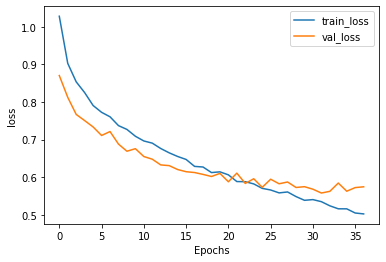

In [478]:
plot_graphs(history3, 'loss')